In [1]:
import numpy as np
import pandas as pd
from skimage.transform import rotate, rescale
import matplotlib.pyplot as plt
import fiona
import shapely.geometry as geometry
from shapely.geometry import Point
from shapely.affinity import rotate
from descartes import PolygonPatch
import pylab as pl
from src import *

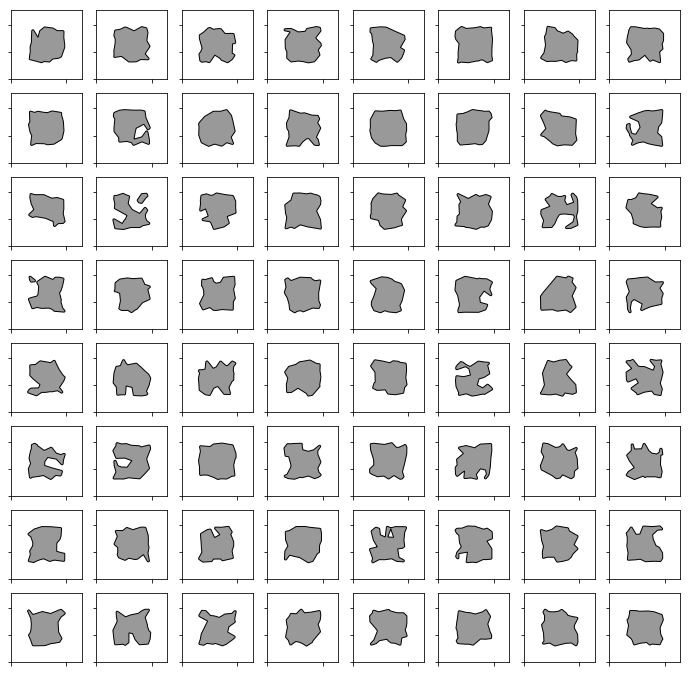

In [2]:
n_point = 60; alpha = .2
fig = pl.figure(figsize=(12,12))

for i in range(64):
    a = np.random.uniform(16,48,size=(n_point,2))
    points = [Point(a[i]) for i in range(n_point)]
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)

    ax = fig.add_subplot(8,8,i+1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim([0, 64]) #ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([0, 64])
    patch = PolygonPatch(concave_hull.buffer(1), fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)    

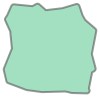

In [3]:
rotate(concave_hull.buffer(1),180)

In [4]:
#Point(100,100).within(concave_hull.buffer(1))